In [17]:
import math

import torch
from sklearn.datasets import  make_gaussian_quantiles
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import logging
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader,Dataset
from sklearn.manifold import TSNE
import random
from torch.optim.lr_scheduler import ExponentialLR
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
LARGE_NUMBER = 1e9
norm=1.

In [18]:
def pre_data(radius=0.7):
    X1 = np.ones((5000,3))
    Y1 = np.ones(5000)
    X2 = np.ones((5000,3))
    Y2 = np.ones(5000)
    X = np.random.uniform(0,1, (5000, 2))*2*np.pi-np.pi
    X1[:,0] = np.cos(X[:,0])
    X1[:,1] = np.sin(X[:,0])
    Y1 = np.zeros((1,5000)).flatten()
    X = np.random.uniform(0,1, (5000, 2))*2*np.pi-np.pi
    X2[:,0] = np.cos(X[:,0])
    X2[:,1] = np.sin(X[:,0])
    Y2 = np.ones((1,5000)).flatten()

    #generate uniform training anchor data
    for i in range(len(Y1)):
        Y1[i] = 0
        leng = np.random.uniform(0,radius)
        leng = math.sqrt(leng)
        X1[i,0] = leng *X1[i,0]
        X1[i,1] = leng *X1[i,1]
        X1[i,2] = math.sqrt(1-X1[i,1]**2-X1[i,0]**2)
    for i in range(len(Y2)):
        Y2[i] = 1
        leng = np.random.uniform(0,radius)
        leng = math.sqrt(leng)
        X2[i,0] = leng *X2[i,0]
        X2[i,1] = leng *X2[i,1]
        X2[i,2] = -1*math.sqrt(1-X2[i,1]**2-X2[i,0]**2)
    fig =plt.figure()
    axe3d =Axes3D(fig)
    axe3d.scatter(X1[:,0],X1[:,1],X1[:,2],marker='o',c='b',s=3)
    axe3d.scatter(X2[:,0],X2[:,1],X2[:,2],marker='o',c='r',s=3)
    plt.savefig('dataset.jpg')
    plt.close()
    X1 = torch.from_numpy(X1).type(torch.FloatTensor)
    Y1 = torch.from_numpy(Y1).type(torch.LongTensor)
    X2 = torch.from_numpy(X2).type(torch.FloatTensor)
    Y2 = torch.from_numpy(Y2).type(torch.LongTensor)
    X_train = torch.cat((X1,X2),0)
    Y_train = torch.cat((Y1,Y2),0)
    for i in range(len(X_train)):
        if i%2 ==0:
            X_train[i] = X1[i//2]
            Y_train[i] = Y1[i//2]
        else:
            X_train[i] = X2[i//2]
            Y_train[i] = Y2[i//2]
    X1 = np.ones((5000,3))
    Y1 = np.ones(5000)
    X2 = np.ones((5000,3))
    Y2 = np.ones(5000)
    X = np.random.uniform(0,1, (5000, 2))*2*np.pi-np.pi
    X1[:,0] = np.cos(X[:,0])
    X1[:,1] = np.sin(X[:,0])
    Y1 = np.zeros((1,5000)).flatten()
    X = np.random.uniform(0,1, (5000, 2))*2*np.pi-np.pi
    X2[:,0] = np.cos(X[:,0])
    X2[:,1] = np.sin(X[:,0])
    Y2 = np.ones((1,5000)).flatten()

    #generate uniform test data
    for i in range(len(Y1)):
        Y1[i] = 0
        leng = np.random.uniform(0,radius)
        leng = math.sqrt(leng)
        X1[i,0] = leng *X1[i,0]
        X1[i,1] = leng *X1[i,1]
        X1[i,2] = math.sqrt(1-X1[i,1]**2-X1[i,0]**2)
    for i in range(len(Y2)):
        Y2[i] = 1
        leng = np.random.uniform(0,radius)
        leng = math.sqrt(leng)
        X2[i,0] = leng *X2[i,0]
        X2[i,1] = leng *X2[i,1]
        X2[i,2] = -1*math.sqrt(1-X2[i,1]**2-X2[i,0]**2)
    X1 = torch.from_numpy(X1).type(torch.FloatTensor)
    Y1 = torch.from_numpy(Y1).type(torch.LongTensor)
    X2 = torch.from_numpy(X2).type(torch.FloatTensor)
    Y2 = torch.from_numpy(Y2).type(torch.LongTensor)
    X_test = torch.cat((X1,X2),0)
    Y_test = torch.cat((Y1,Y2),0)
    return X_train,Y_train,X_test,Y_test


In [19]:
def infonce_loss(z,tau,epoch):
    n = z.shape[0]
    z = F.normalize(z, p=2, dim=1) / np.sqrt(tau)
    m = 2
    labels = (np.repeat(np.arange(n), m) + np.tile(np.arange(m) * n//m, n)) % n
    labels = labels.reshape(n, m)[:, 1:].reshape(-1)
    logits = z @ z.t()
    logits[np.arange(n), np.arange(n)] = -LARGE_NUMBER
    logprob = F.log_softmax(logits, dim=1)
    labels = (np.repeat(np.arange(n), m) + np.tile(np.arange(m) * n//m, n)) % n
    labels = labels.reshape(n, m)[:, 1:].reshape(-1)
    loss = -logprob[np.repeat(np.arange(n), m-1), labels].sum() / n / (m-1) / norm

    return loss


In [20]:
def prepare_network(e_dim=256, lr=1, lr2=1):
    net = nn.Sequential(
                nn.Linear(3,e_dim),
                nn.ReLU(),
                nn.Linear(e_dim,e_dim),
                nn.ReLU(),
                nn.Linear(e_dim,e_dim),
                nn.Softmax(dim=1),
            )
    net = net.to('cuda:0')
    net2 = nn.Sequential(nn.Linear(e_dim,2),nn.Softmax(dim=1)).to('cuda:0')
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    optimizer2 = torch.optim.SGD(net2.parameters(),lr=lr2)
    Loss = infonce_loss


    return net,net2,optimizer,optimizer2,Loss

In [21]:
def uni_aug(v1,v2,eps):
    shape = v1.size()
    noise = torch.cuda.FloatTensor(shape).to("cuda:0")
    torch.rand(shape, out=noise)
    noise = noise-0.5
    noise =noise*2
    v1 +=noise*eps
    noise = torch.cuda.FloatTensor(shape).to("cuda:0")
    torch.rand(shape, out=noise)
    noise = noise-0.5
    noise =noise*2
    v2 +=noise*eps
    return v1,v2

In [22]:
def tsne_vis(x_train,y_train,net,t,tt):
    tsne = TSNE(n_components=2)
    feature = net(x_train[0:1000])
    result = tsne.fit_transform(feature.clone().detach().cpu())
    x_min, x_max = np.min(result,0),np.max(result,0)
    result=(result-x_min) /(x_max-x_min)
    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(len(feature)):
        #print(i)
        if y_train[i]==0:
            plt.scatter(result[i,0],result[i,1],marker='o',c='b',s=3)
        else:
            plt.scatter(result[i, 0], result[i, 1],marker='o',c='r',s=3)
    plt.savefig('tsne'+str(t) + str(tt))
    plt.close()

In [23]:
epsset=[0,0.0001,0.1,3,10]
def training(e_dim=256, lr=1, lr2=1, total_epoch=1000):

    logger = logging.getLogger(__name__)
    logger.setLevel(level=logging.INFO)
    handler = logging.FileHandler("log.txt")
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)


    for t in range(1):
        for tt in range(5):
            eps=epsset[tt]
            torch.cuda.set_device(0)
            device ='cuda:0'
   
            #prepare dataset
            x_train,y_train,x_test,y_test = pre_data(0.7)
            x_train = x_train.to('cuda:0')
            y_train = y_train.to('cuda:0')
            x_test = x_test.to('cuda:0')
            y_test = y_test.to('cuda:0')
            writer = SummaryWriter()

            #prepare optimzer network 
            net,net2,optimizer,optimizer2,Loss = prepare_network(e_dim,lr,lr2)
            #Loss=nn.CrossEntropyLoss()
            y_train=y_train.type(torch.LongTensor)
            for epoch in range(total_epoch):
                #print(epoch)
                #random shuffle
                shuffle = torch.randperm(10000)
                x_train = x_train[shuffle]
                y_train = y_train[shuffle]



                for j in range(5000//256):
                    v1 = x_train[256*j:256*j+256].clone()
                    v2 = x_train[256*j:256*j+256].clone()
                    v1,v2 = uni_aug(v1,v2,eps)


                    feature1 = net(v1)
                    feature2 = net(v2)
                    feature = torch.cat((feature1,feature2),dim=0)
                    loss=Loss(feature,0.1,epoch)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                if epoch == total_epoch-1:
                   tsne_vis(x_train, y_train, net, t, tt)

            #linear classifier
            Loss = nn.CrossEntropyLoss()
            for i in range(50):
                for j in range(5000//256):
                    v1 = x_train[256*j:256*j+256].clone()
                    label1 = y_train[256*j:256*j+256].clone().to("cuda:0")
                    feature1 = net(v1).detach()
                    feature1 = net2(feature1)
                    loss = Loss(feature1,label1)
                    optimizer2.zero_grad()
                    loss.backward()
                    optimizer2.step()


            feature=net(x_test.to('cuda:0'))
            feature = net2(feature)
            y_test=y_test.to('cuda:0')
            print("test_acc:",torch.sum((feature.argmax(1)==y_test).float()))
            logger.info(str(t))
            logger.info(str(eps))
            feature = net(x_train.to("cuda:0"))
            feature = net2(feature)
            y_train=y_train.to("cuda:0")
            print("train_acc"+str(torch.sum((feature.argmax(1)==y_train).float())/len(y_train)))
            logger.info("train_acc"+str(torch.sum((feature.argmax(1)==y_train).float())/len(y_train)))





In [24]:
training(1000)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
INFO:__main__:0
INFO:__main__:0
INFO:__main__:train_acctensor(0.5000, device='cuda:0')


test_acc: tensor(5000., device='cuda:0')
train_acctensor(0.5000, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
INFO:__main__:0
INFO:__main__:0.0001
INFO:__main__:train_acctensor(0.9455, device='cuda:0')


test_acc: tensor(9480., device='cuda:0')
train_acctensor(0.9455, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
INFO:__main__:0
INFO:__main__:0.1
INFO:__main__:train_acctensor(1., device='cuda:0')


test_acc: tensor(10000., device='cuda:0')
train_acctensor(1., device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
INFO:__main__:0
INFO:__main__:3
INFO:__main__:train_acctensor(0.5000, device='cuda:0')


test_acc: tensor(5000., device='cuda:0')
train_acctensor(0.5000, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
INFO:__main__:0
INFO:__main__:10
INFO:__main__:train_acctensor(0.5000, device='cuda:0')


test_acc: tensor(5000., device='cuda:0')
train_acctensor(0.5000, device='cuda:0')


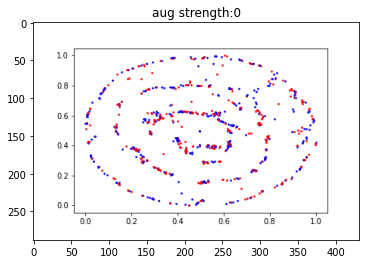

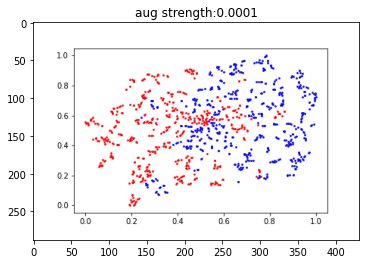

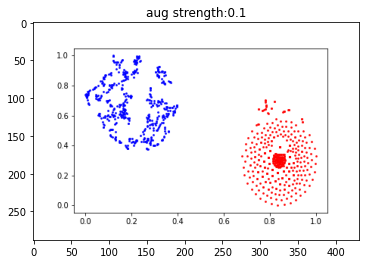

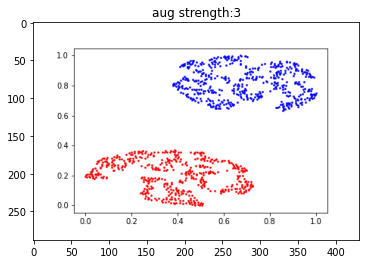

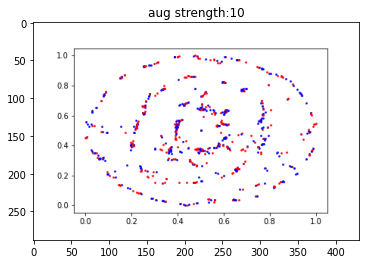

In [25]:
for t in range(1):
  for tt in range(5):
    figure = plt.imread('tsne'+str(t)+str(tt)+'.png')
    fig=plt.figure()
    plt.imshow(figure)     
    plt.title('aug strength:'+str(epsset[tt]))